<a href="https://colab.research.google.com/github/tatendatobaiwa/cnn/blob/main/cnnmodel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***SIMPLE CNN MODEL BUILD FOR LUNG CANCER IMAGING***

**Step 1: Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 2: Create Directories in Drive**

**Step 3: Install Dependenices**

In [2]:
!pip install -q tensorflow==2.13.0
!pip install -q tensorflow-addons==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 27.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.20.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.8

In [3]:
import tensorflow as tf
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

project_path = '/content/drive/MyDrive/cnnprojectfinal'
sys.path.append(project_path)

**Mini Step 3a: Verify Fixes**

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Addons version: {tfa.__version__}")

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow version: 2.13.0
TensorFlow Addons version: 0.23.0


**Step 4: Use a script to Load and Preprocess Data**

In [5]:
import cv2
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

class DataProcessor:
    def __init__(self, base_path="/content/drive/MyDrive/cnnprojectfinal", target_size=(224, 224)):
        """
        Initialize the DataProcessor.

        Parameters:
          - base_path: Root directory of your project.
          - target_size: Desired image size (width, height).
                         We use (224, 224) because MobileNetV2 is optimized for this size.
        """
        self.base_path = Path(base_path)
        self.target_size = target_size
        self.train_path = self.base_path / "data/raw/train"
        self.test_path = self.base_path / "data/raw/test"

        # Verify that the training directory exists
        if not self.train_path.exists():
            raise FileNotFoundError(f"Train directory {self.train_path} does not exist.")
        if not self.test_path.exists():
            print(f"Warning: Test directory {self.test_path} does not exist.")

    def load_images(self, directory, use_clahe=False):
        """
        Loads images from a given directory, resizes them, and optionally applies CLAHE.

        Parameters:
          - directory: Path to the image directory (should contain subdirectories for each class).
          - use_clahe: Boolean flag to apply CLAHE for contrast enhancement.

        Returns:
          - images: NumPy array of images.
          - labels: NumPy array of corresponding labels (integers based on class index).
        """
        images = []
        labels = []
        class_names = ['benign', 'malignant', 'normal']

        for label, class_name in enumerate(class_names):
            class_dir = directory / class_name
            if not class_dir.exists():
                print(f"Warning: {class_dir} does not exist. Skipping this class.")
                continue
            for img_path in class_dir.glob('*'):
                if img_path.suffix.lower() in ('.png', '.jpg', '.jpeg'):
                    # Read image in grayscale
                    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Warning: Unable to load image {img_path}")
                        continue
                    # Optionally apply CLAHE for contrast enhancement
                    if use_clahe:
                        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                        img = clahe.apply(img)
                    # Resize image to the target size (e.g., 224x224)
                    img = cv2.resize(img, self.target_size)
                    images.append(img)
                    labels.append(label)
        return np.array(images), np.array(labels)

    def create_generators(self, batch_size=32, use_clahe=False):
        """
        Creates data generators for training and validation.

        Returns:
          - train_generator: Augmented generator for training data.
          - val_generator: Generator for validation data (no augmentation).
          - X_val, y_val: Validation images and labels (for evaluation and visualization).
        """
        # Load images from the training directory and normalize pixel values to [0,1]
        X_train, y_train = self.load_images(self.train_path, use_clahe=use_clahe)
        # Add channel dimension (since images are grayscale) and scale pixel values
        X_train = X_train[..., np.newaxis] / 255.0

        # Split the data into training and validation sets with stratification
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
        )

        # Set up data augmentation for the training data.
        # Adjust parameters here as needed; brightness_range and geometric transformations are provided.
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.5],  # Adjusted range; you can experiment with these values.
            fill_mode='nearest'
        )
        # No augmentation is applied to the validation data.
        val_datagen = ImageDataGenerator()

        train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
        val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)

        return train_generator, val_generator, X_val, y_val

    def show_augmented_images(self, generator, n_images=5, gamma=1.0):
        """
        Visualizes a few augmented images from a given generator.

        Parameters:
          - generator: The image data generator.
          - n_images: Number of images to display.
          - gamma: Gamma correction factor (gamma < 1 brightens the image).
        """
        images, labels = next(generator)
        plt.figure(figsize=(15, 3))
        for i in range(n_images):
            img = images[i].squeeze()
            if gamma != 1.0:
                img = np.power(img, 1.0/gamma)
            plt.subplot(1, n_images, i+1)
            plt.imshow(img, cmap='gray', vmin=0, vmax=1)
            plt.title(f"Label: {labels[i]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()


**Step 5: Model Training**

9406464/9406464 [==============================] - 0s 0us/step
🚀 Starting initial training...
Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 1.3301 - accuracy: 0.5359
Epoch 1: val_loss improved from inf to 1.54646, saving model to /content/drive/MyDrive/cnnprojectfinal/best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 78s 3s/step - loss: 1.3301 - accuracy: 0.5359 - val_loss: 1.5465 - val_accuracy: 0.4182 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 0.9496 - accuracy: 0.6465
Epoch 2: val_loss improved from 1.54646 to 1.42823, saving model to /content/drive/MyDrive/cnnprojectfinal/best_model.h5
28/28 [==============================] - 72s 3s/step - loss: 0.9496 - accuracy: 0.6465 - val_loss: 1.4282 - val_accuracy: 0.4864 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 0.8511 - accuracy: 0.6899
Epoch 3: val_loss did not improve from 1.42823
28/28 [==============================] - 76s 3s/step - loss: 0.8511 - accuracy: 0.6899 - val_loss: 1.5386 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - ETA: 0s - loss: 0.8788 - accuracy: 0.6591
Epoch 4: val_loss improved from 1.42823 to 1.10209, saving model to /content/drive/MyDrive/cnnprojectfinal/best_model.h5
28/

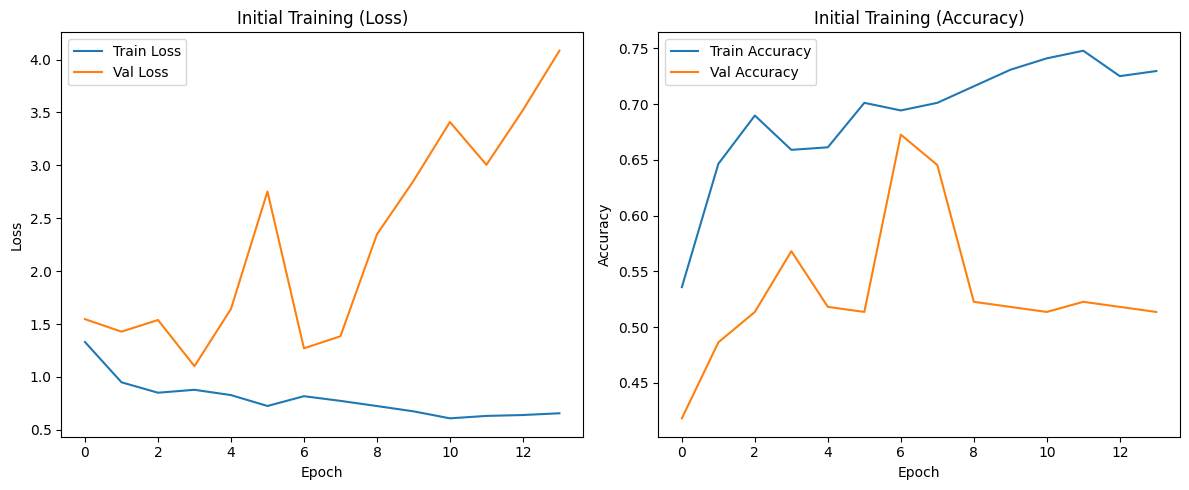

✅ Initial model saved as /content/drive/MyDrive/cnnprojectfinal/best_model.h5
🔧 Starting fine-tuning...
Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 0.7517 - accuracy: 0.6933
Epoch 1: val_loss improved from inf to 1.12211, saving model to /content/drive/MyDrive/cnnprojectfinal/best_model.h5
28/28 [==============================] - 87s 3s/step - loss: 0.7517 - accuracy: 0.6933 - val_loss: 1.1221 - val_accuracy: 0.5818 - lr: 1.0000e-05
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 0.7244 - accuracy: 0.7184
Epoch 2: val_loss did not improve from 1.12211
28/28 [==============================] - 82s 3s/step - loss: 0.7244 - accuracy: 0.7184 - val_loss: 1.1829 - val_accuracy: 0.5727 - lr: 1.0000e-05
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.7138
Epoch 3: val_loss did not improve from 1.12211
28/28 [==============================] - 79s 3s/step - loss: 0.6851 - accuracy: 0.7138 - val_loss: 1.2589 - val

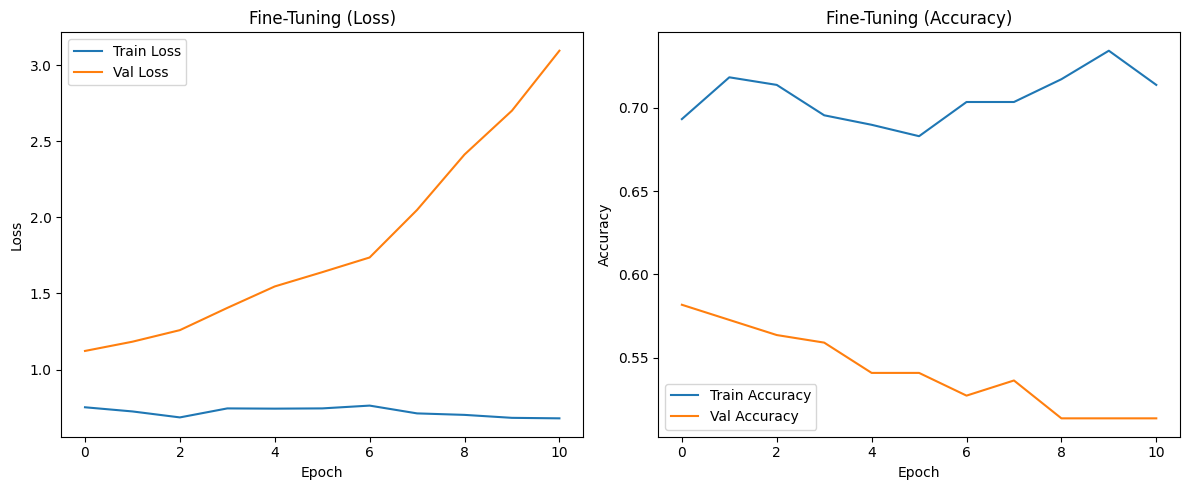

✅ Final model saved as /content/drive/MyDrive/cnnprojectfinal/final_model.h5


In [ ]:
import sys
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Set your project root path (the folder that contains the utils directory)
project_path = '/content/drive/MyDrive/cnnprojectfinal'
if project_path not in sys.path:
    sys.path.append(project_path)

# Import the DataProcessor from the utils directory.
from utils.data_processing import DataProcessor
# Import the transfer model function.
from utils.model_transfer import create_model_transfer

#############################################
# Training and Plotting Functions
#############################################
def train_model(model, train_generator, val_generator, epochs, checkpoint_path):
    """
    Trains the model using callbacks for early stopping, checkpointing, and learning rate reduction.
    """
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    callbacks = [early_stop, checkpoint, reduce_lr]

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return history

def plot_training_history(history, title="Training History"):
    """
    Plots the training and validation loss and accuracy.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title + " (Loss)")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title + " (Accuracy)")

    plt.tight_layout()
    plt.show()

#############################################
# Main Training and Fine-Tuning Workflow
#############################################
if __name__ == '__main__':
    # Initialize the data processor.
    # (Assuming that your data_processing.py now outputs images at 224x224.)
    processor = DataProcessor(target_size=(224, 224))
    train_gen, val_gen, X_val, y_val = processor.create_generators(batch_size=32)

    # Define path to save the best model.
    model_path = '/content/drive/MyDrive/cnnprojectfinal/best_model.h5'

    # Create the MobileNetV2-based transfer learning model.
    model = create_model_transfer(input_shape=(224, 224, 1), num_classes=3)

    print("🚀 Starting initial training...")
    # Initial training phase.
    initial_epochs = 50
    history_initial = train_model(model, train_gen, val_gen, epochs=initial_epochs, checkpoint_path=model_path)
    plot_training_history(history_initial, title="Initial Training")

    # Save the best model from the initial training phase.
    model.save(model_path)
    print(f"✅ Initial model saved as {model_path}")

    # ----------------- Fine-Tuning Phase -----------------
    print("🔧 Starting fine-tuning...")

    # Retrieve the MobileNetV2 base model from the constructed model.
    base_model = model.get_layer("MobileNetV2_base")
    # Unfreeze the base model for fine-tuning.
    base_model.trainable = True
    # Optionally, freeze the earlier layers of the base model.
    # Here, we unfreeze the last 30 layers and freeze the rest.
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Recompile the model with a lower learning rate for fine-tuning.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Fine-tune the model for additional epochs.
    fine_tune_epochs = 20
    history_fine = train_model(model, train_gen, val_gen, epochs=fine_tune_epochs, checkpoint_path=model_path)
    plot_training_history(history_fine, title="Fine-Tuning")

    # Save the final fine-tuned model.
    final_model_path = '/content/drive/MyDrive/cnnprojectfinal/final_model.h5'
    model.save(final_model_path)
    print(f"✅ Final model saved as {final_model_path}")


**Step 6: Model Evaluation**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_model(model, X_val, y_val, class_names=['benign', 'malignant', 'normal'], compute_auc=False):
    """
    Evaluates the model on the validation data and prints key metrics.

    Parameters:
      - model: A trained Keras model.
      - X_val: Validation images (should be preprocessed as during training).
      - y_val: True labels for the validation images.
      - class_names: A list of class names corresponding to the labels.
      - compute_auc: If True, computes and prints the ROC-AUC score for multi-class classification.

    Outputs:
      - Classification report (precision, recall, f1-score, support).
      - Confusion matrix plot.
      - Class-wise accuracy and overall accuracy.
      - (Optionally) ROC-AUC Score.
    """
    # Generate predictions (probabilities) and convert them to class labels.
    y_pred_probs = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Print classification report.
    print("Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=class_names))

    # Plot the confusion matrix.
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Compute and print class-wise accuracy.
    class_acc = {}
    for i, class_name in enumerate(class_names):
        mask = (y_val == i)
        class_acc[class_name] = np.mean(y_pred_classes[mask] == y_val[mask])
    print("Class-wise Accuracy:")
    for class_name, acc in class_acc.items():
        print(f"{class_name}: {acc:.2%}")

    # Compute and print overall accuracy.
    overall_acc = accuracy_score(y_val, y_pred_classes)
    print(f"Overall Accuracy: {overall_acc:.2%}")

    # Optionally compute ROC-AUC score for multi-class classification.
    if compute_auc:
        try:
            # Binarize the true labels for multi-class ROC-AUC.
            y_val_binarized = label_binarize(y_val, classes=range(len(class_names)))
            auc = roc_auc_score(y_val_binarized, y_pred_probs, multi_class='ovr')
            print(f"ROC-AUC Score: {auc:.4f}")
        except Exception as e:
            print("Error computing ROC-AUC Score:", e)


In [ ]:
# Run the evaluation function
from utils.evaluate import evaluate_model
evaluate_model(model, X_val, y_val)

ModuleNotFoundError: No module named 'utils'

**Step 8: Implementation of Explainable AI (Grad-CAM)**

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name='conv2d_2', class_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.

    Parameters:
      - model: A trained Keras model.
      - img_array: Preprocessed image array of shape (1, H, W, C).
      - layer_name: Name of the convolutional layer to use for Grad-CAM.
      - class_index: (Optional) Integer representing the target class. If None,
                     the class with the highest predicted probability is used.

    Returns:
      - superimposed_img: The original image (in BGR) overlaid with the Grad-CAM heatmap.
    """
    # Create a model that maps the input image to the activations of the target layer and the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Forward pass: obtain the convolutional layer output and predictions
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        # Compute the loss for the target class
        loss = predictions[:, class_index]

    # Compute the gradient of the loss with respect to the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)
    # Global average pool the gradients across the width and height dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the convolutional outputs for the first image in the batch
    conv_outputs = conv_outputs[0]
    # Multiply each channel in the feature map array by its corresponding gradient importance
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()

    # Apply ReLU to the heatmap to keep only positive contributions
    heatmap = np.maximum(heatmap, 0)
    # Normalize the heatmap (avoid division by zero)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    # Resize the heatmap to match the input image dimensions (assumes img_array is (1, H, W, C))
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    # Convert heatmap to 8-bit and apply a color map
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Prepare the original image for superimposition:
    # Assume the original image is grayscale (with one channel), so squeeze it and convert to uint8.
    img = np.uint8(255 * img_array[0].squeeze())
    # Convert grayscale to BGR
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # Superimpose the heatmap on the original image with a chosen intensity
    superimposed_img = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    return superimposed_img

def visualize_explanations(model, X_val, y_val, num_samples=3):
    """
    Visualizes Grad-CAM explanations for a random set of samples from the validation data.

    Parameters:
      - model: A trained Keras model.
      - X_val: Array of validation images (preprocessed as during training).
      - y_val: Array of true labels corresponding to X_val.
      - num_samples: Number of samples to visualize.
    """
    class_names = ['benign', 'malignant', 'normal']
    # Randomly select indices for visualization
    indices = np.random.choice(len(X_val), num_samples, replace=False)

    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices, 1):
        img = X_val[idx]
        true_label = class_names[y_val[idx]]

        # Get model prediction for the image
        pred = model.predict(np.expand_dims(img, axis=0))
        pred_class = class_names[np.argmax(pred)]

        # Generate Grad-CAM explanation
        explanation = grad_cam(model, np.expand_dims(img, axis=0))

        # Plot original image with true and predicted labels
        plt.subplot(num_samples, 2, 2 * i - 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_class}")
        plt.axis('off')

        # Plot the Grad-CAM explanation
        plt.subplot(num_samples, 2, 2 * i)
        plt.imshow(explanation)
        plt.title("Grad-CAM Explanation")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Visualize model explanations

from utils.xai import visualize_explanations
visualize_explanations(model, X_val, y_val, num_samples=3)

**Step 9: Testing Model Accuracy on Test images**

In [ ]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def load_test_images(test_dir, target_size=(224, 224)):
    """
    Loads and preprocesses test images from the specified directory.

    Parameters:
      - test_dir: Path to the test images directory.
      - target_size: Desired size for the images (width, height).

    Returns:
      - images: NumPy array of test images (with shape (N, H, W, 1) and normalized to [0,1]).
      - image_paths: List of image file paths.
    """
    test_dir = Path(test_dir)
    images = []
    image_paths = list(test_dir.glob('*'))
    for img_path in image_paths:
        if img_path.suffix.lower() in ('.png', '.jpg', '.jpeg'):
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, target_size)
                # Add channel dimension and normalize to [0,1]
                images.append(img[..., np.newaxis] / 255.0)
    return np.array(images), image_paths

# Example usage:
# Assuming your model is loaded in a variable called `model`
# and you want to test on images from your test folder.
test_images, test_paths = load_test_images("/content/drive/MyDrive/cnnprojectfinal/data/raw/test", target_size=(224, 224))

# Get predictions for the test images.
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Print results for each test image.
class_names = ['benign', 'malignant', 'normal']
for path, pred_class in zip(test_paths, predicted_classes):
    print(f"Image: {path.name}, Predicted Class: {class_names[pred_class]}")

# Optionally, visualize Grad-CAM explanations for a few test images.
# Here we reuse the visualize_explanations function from xai.py.
from utils.xai import visualize_explanations
# Note: Ensure test_images and corresponding labels are available.
# If you have true labels for the test set, supply them; otherwise, you can set dummy labels.
dummy_labels = np.zeros(len(test_images), dtype=int)  # Replace with true labels if available
visualize_explanations(model, test_images, dummy_labels, num_samples=3)
